# Segmentation of Indian Traffic

In [ ]:
!pip install tensorflow==2.2.0
!pip install keras==2.3.1
!pip install -U segmentation-models==0.2.1

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm.notebook import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import urllib.request
import pathlib
from pathlib import Path

from tqdm.notebook import tqdm

# https://drive.google.com/drive/folders/1bynkOIXCurhJ9_Y5Q14KWX5yDyCRkKfN

In [ ]:
if 'data.zip' not in os.listdir(): 
    !wget https://www.dropbox.com/s/cok7zvnqukm8fok/data.zip
    get_ipython().system_raw("7z x data.zip")

<pre>
1. Download the data from this link, and extract it

2. All the data will be in the folder "data" 


|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    root = pathlib.Path(root_dir)
    img_paths = list(root.rglob("*.jpg*"))
    img_paths_lst = [str(path) for path in img_paths]
    
    frame_name_lst = []
    for p in img_paths_lst:
        frame_name =  '/'.join(p.split("_")[0].split('/')[-2:])
        frame_name_lst.append(frame_name)
    img_frame_df = pd.DataFrame(list(zip(img_paths_lst, frame_name_lst)), columns =['image', 'frame_name'])

    root = pathlib.Path(root_dir)
    json_paths = list(root.rglob("*.json*"))

    json_paths_lst = [str(path) for path in json_paths]

    frame_name_lst = []
    for p in json_paths_lst:
        frame_name = '/'.join(p.split("_")[0].split('/')[-2:])
        frame_name_lst.append(frame_name)
    json_frame_df = pd.DataFrame(list(zip(json_paths_lst, frame_name_lst)), columns =['json', 'frame_name'])

    data_df = pd.merge(img_frame_df, json_frame_df, on='frame_name')
    data_df = data_df.drop('frame_name', axis=1)
    return data_df

In [ ]:
data_df = return_file_names_df(root_dir='data')
data_df.head()

,image,json
0,data/images/329/frame6653_leftImg8bit.jpg,data/mask/329/frame6653_gtFine_polygons.json
1,data/images/329/frame3203_leftImg8bit.jpg,data/mask/329/frame3203_gtFine_polygons.json
2,data/images/329/frame4673_leftImg8bit.jpg,data/mask/329/frame4673_gtFine_polygons.json
3,data/images/329/frame5933_leftImg8bit.jpg,data/mask/329/frame5933_gtFine_polygons.json
4,data/images/329/frame7073_leftImg8bit.jpg,data/mask/329/frame7073_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels=set()
    for json_file in tqdm(data_df['json'].values):
        with open(json_file) as f:
            json_data = json.load(f)
            for jd_obj in json_data['objects']:
                unique_labels.add(jd_obj['label'])

    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

In [ ]:
len(unique_labels)

40

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    label = []
    vertexlist = []
    
    with open(file) as f:
        json_data = json.load(f)
        w = json_data['imgWidth']
        h = json_data['imgHeight']
        for jd_obj in json_data['objects']:
            label.append(jd_obj['label'])
            vertex_i = []
            for vi in jd_obj['polygon']:
                vertex_i.append(tuple(vi))
            vertexlist.append(vertex_i)

    return w, h, label, vertexlist

## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3

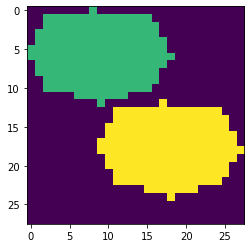

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("L", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
print(img.shape)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img)
print(img//10)
im = Image.fromarray(img, mode='L')
im.save("test_image.png")

In [ ]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    mask_path_lst = []
    for img_file, json_file in tqdm(data_df.values):
        # get w, h, labels and vertex list from this json file
        w, h, labels, vertexlist = get_poly(json_file)
        #print("Working on json file=",json_file)
        img = Image.new("L", (w, h))    # 'L' creates a gray scale image. 
                                        # Refer different modes, https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
        img1 = ImageDraw.Draw(img)
        
        for i in range(len(vertexlist)):
            try:
                img1.polygon(vertexlist[i], fill=label_clr[labels[i]])
            except:
                #print("json file=",json_file,";label",labels[i],";vertex is=",vertexlist[i])
                pass

        path_tokens = json_file.split("/")
        data_root = path_tokens[0]
        output = 'output'
        scene = path_tokens[2]

        Path('/'.join([data_root,output,scene])).mkdir(parents=True, exist_ok=True)
        frame_number = path_tokens[3].split(".")[0]

        mask_path = '/'.join([data_root,output,scene,frame_number])
        mask_path += ".png"
        img.save(mask_path, format="png")
        mask_path_lst.append(mask_path)

    data_df['mask'] = mask_path_lst
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

,image,json,mask
0,data/images/329/frame6653_leftImg8bit.jpg,data/mask/329/frame6653_gtFine_polygons.json,data/output/329/frame6653_gtFine_polygons.png
1,data/images/329/frame3203_leftImg8bit.jpg,data/mask/329/frame3203_gtFine_polygons.json,data/output/329/frame3203_gtFine_polygons.png
2,data/images/329/frame4673_leftImg8bit.jpg,data/mask/329/frame4673_gtFine_polygons.json,data/output/329/frame4673_gtFine_polygons.png
3,data/images/329/frame5933_leftImg8bit.jpg,data/mask/329/frame5933_gtFine_polygons.json,data/output/329/frame5933_gtFine_polygons.png
4,data/images/329/frame7073_leftImg8bit.jpg,data/mask/329/frame7073_gtFine_polygons.json,data/output/329/frame7073_gtFine_polygons.png


# Task 2: Applying Unet to segment the images

<pre>
* check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* Library for UNet<a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

</pre>

### Task 2.1: Dice loss

In [ ]:
# Understanding dice and iou scores
# --------------------------------------
# https://stats.stackexchange.com/a/488098
# https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
# https://stats.stackexchange.com/a/276144

### <font color='purple'>**Understanding Dice Loss**</font>

Refer my document,<br>
<a href='https://docs.google.com/document/d/1UsM_yVpbeN_YUCk8Mrk2yDpdgCNligYMu0mfG_Fmg6w/edit?usp=sharing'>https://docs.google.com/document/d/1UsM_yVpbeN_YUCk8Mrk2yDpdgCNligYMu0mfG_Fmg6w/edit?usp=sharing</a>

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
</pre>

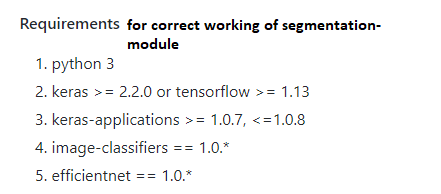

In [ ]:
import tensorflow
import tensorflow as tf
# tf.config.experimental_run_functions_eagerly(True)
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import keras

import random as rn

# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models

import segmentation_models as sm
from segmentation_models import Unet
#sm.set_framework('tf.keras')
tensorflow.keras.backend.set_image_data_format('channels_last')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
tensorflow.keras.backend.clear_session()

model_unet = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', encoder_freeze=True, input_shape=(512,512,3))
model_unet.summary()
# ft_model_input = base_unet.output
# x1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(ft_model_input)
# x1 = BatchNormalization()(x1)

# x2= Conv2D(10, kernel_size=3,strides=1,padding = "same", activation="relu")(x1)
# x2 = BatchNormalization()(x2)

# x3 = Conv2D(10, kernel_size=3,strides=1,padding = "same", activation="relu")(x2)
# x3 = BatchNormalization()(x3)

# x_out = Conv2D(21, kernel_size=2,strides=1,padding = "same", activation="relu")(x3)

# model_unet = Model(base_unet.input, x_out)
# model_unet.summary()

85524480/85521592 [==============================] - 2s 0us/step
Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_1[0][0]           
________________________

In [ ]:
# import imgaug.augmenters as iaa
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
data_df = pd.read_csv("preprocessed_data.csv")

In [ ]:
from sklearn.model_selection import train_test_split
X_train_df, X_test_df = train_test_split(data_df, test_size=0.20, random_state=42)

In [ ]:
print(X_train_df.shape)
print(X_test_df.shape)

(3206, 3)
(802, 3)


In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(image[:,:,0].shape)
        plt.imshow(image[:,:,0])
    plt.show()

(512, 512)


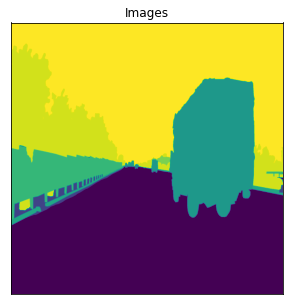

In [ ]:
abc = cv2.imread(X_train_df['mask'].values[0])
visualize(images=abc)

In [ ]:
class Dataset:
    def __init__(self, paths_df, label_clr, is_training=False):
        #self.ids = file_names
        # the paths of images
        self.images_fps = paths_df['image'].values
        # the paths of segmentation images
        self.masks_fps = paths_df['mask'].values
        # giving labels for each class
        #self.class_values = list(map(lambda x: x//10, set(label_clr.values()))) # This will get us all 21 classes from the 'label_clr', ranging from 0 to 20
        self.class_values = set(label_clr.values())
        self.is_training = is_training

    # def normalize_image(self, mask):
    #     mask = mask/255
    #     return mask
    
    def __getitem__(self, i):
        # read data
        full_size_image = cv2.imread(self.images_fps[i])
        #full_size_image = full_size_image[:,:,0]
        image = cv2.resize(full_size_image, (512,512), interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        full_size_mask  = cv2.imread(self.masks_fps[i])
        #full_size_mask = full_size_mask[:,:,0]
        image_mask = cv2.resize(full_size_mask, (512,512), interpolation=cv2.INTER_AREA)
        image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)
        #image_mask = self.normalize_image(image_mask)
        
        image_masks = [(image_mask[:,:,0] == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if self.is_training:
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
BATCH_SIZE=8
# Dataset for train images
train_dataset = Dataset(X_train_df, label_clr, is_training=True)
test_dataset  = Dataset(X_test_df, label_clr, is_training=False)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 512, 512, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 512, 512, 21)

(8, 512, 512, 3)


In [ ]:
len(train_dataloader)

400

<b>CCE loss vs Dice loss</b><br>
<a href='https://gchlebus.github.io/2018/02/18/semantic-segmentation-loss-functions.html'>https://gchlebus.github.io/2018/02/18/semantic-segmentation-loss-functions.html</a>

In [ ]:
from segmentation_models.metrics import iou_score

#optim = tensorflow.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
# or total_loss = sm.losses.categorical_focal_dice_loss 

#opt_adam = tf.keras.optimizers.Adam(0.001)

#model.compile(optimizer=opt, loss=ssd_loss.compute_loss)

model_unet.compile(optimizer='adam', loss=focal_loss, metrics=[iou_score])

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('best_unet_model.hdf5', save_weights_only=False, save_best_only=True, \
                                       verbose=1, mode='max', monitor='val_iou_score'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.00001, patience=2, cooldown=1, verbose=1, mode='max')
]

In [ ]:
# For 'Model' object has no attribute 'in_multi_worker_mode' error /
# refer, https://github.com/keras-team/keras/issues/13258

history = model_unet.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=11,\
                              validation_data=test_dataloader,  validation_steps=len(test_dataloader) ,callbacks=callbacks)

Epoch 1/11
400/400 [==============================] - 685s 2s/step - loss: 1.6247 - iou_score: 0.1545 - val_loss: 1.8749 - val_iou_score: 0.1349

Epoch 00001: val_iou_score improved from -inf to 0.13487, saving model to best_unet_model.hdf5
Epoch 2/11
400/400 [==============================] - 653s 2s/step - loss: 1.0977 - iou_score: 0.3921 - val_loss: 1.0891 - val_iou_score: 0.4375

Epoch 00002: val_iou_score improved from 0.13487 to 0.43753, saving model to best_unet_model.hdf5
Epoch 3/11
400/400 [==============================] - 648s 2s/step - loss: 0.9519 - iou_score: 0.4481 - val_loss: 0.9362 - val_iou_score: 0.4498

Epoch 00003: val_iou_score improved from 0.43753 to 0.44985, saving model to best_unet_model.hdf5
Epoch 4/11
400/400 [==============================] - 654s 2s/step - loss: 0.8785 - iou_score: 0.4668 - val_loss: 0.9096 - val_iou_score: 0.4653

Epoch 00004: val_iou_score improved from 0.44985 to 0.46527, saving model to best_unet_model.hdf5
Epoch 5/11
400/400 [=======

In [ ]:
model_unet.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=3,\
                              validation_data=test_dataloader,  validation_steps=len(test_dataloader) ,callbacks=callbacks)

Epoch 1/3
400/400 [==============================] - 665s 2s/step - loss: 0.5412 - iou_score: 0.5611 - val_loss: 0.7743 - val_iou_score: 0.5081

Epoch 00001: val_iou_score improved from 0.49894 to 0.50810, saving model to best_unet_model.hdf5
Epoch 2/3
400/400 [==============================] - 664s 2s/step - loss: 0.5225 - iou_score: 0.5637 - val_loss: 0.7718 - val_iou_score: 0.5088

Epoch 00002: val_iou_score improved from 0.50810 to 0.50881, saving model to best_unet_model.hdf5
Epoch 3/3
400/400 [==============================] - 654s 2s/step - loss: 0.5278 - iou_score: 0.5646 - val_loss: 0.7854 - val_iou_score: 0.5096

Epoch 00003: val_iou_score improved from 0.50881 to 0.50958, saving model to best_unet_model.hdf5


In [ ]:
# LOADING THE SAVED MODEL
#-------------------------
model_best_unet = tf.keras.models.load_model('best_unet_model.hdf5', custom_objects={'cce_dice_loss':sm.losses.cce_dice_loss, 'iou_score':iou_score})
model_best_unet.summary()

In [ ]:
iou_score_test = model_best_unet.evaluate_generator(test_dataloader, steps=len(test_dataloader))[1]
print("Best IOU score:", iou_score_test)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Best IOU score: 0.509581446647644


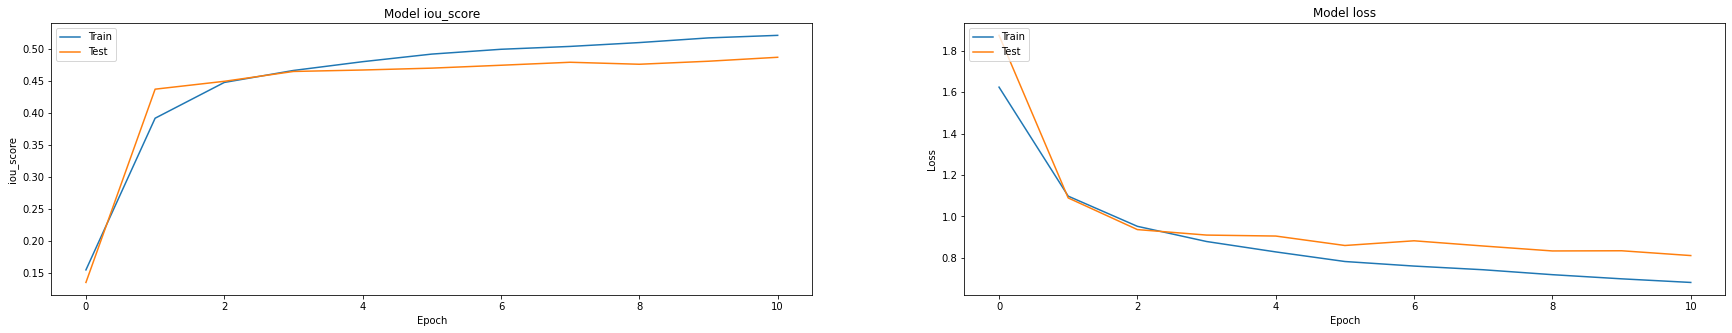

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
def infer_predicted_image(predicted, label_clr):
    classes = list(set(label_clr.values()))
    for i in range(len(classes)):
        predicted[0,:,:,i] = np.where((predicted[0,:,:,i] > 0.5), classes[i], 0)

    predicted = np.sum(predicted, axis=-1)
    return predicted

def predict_image(model, X_df, num_of_images):
    for orig_im, _, mask_im in X_df.values:
        #original image
        image = cv2.imread(orig_im)
        #print("Original image shape =>",image.shape)
        image = cv2.resize(image, (512,512), interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print("Original image Resized shape =>",image.shape)

        #target mask image
        image_mask = cv2.imread(mask_im)
        #print("Mask image shape =>",image_mask.shape)
        image_mask = cv2.resize(image_mask, (512,512), interpolation=cv2.INTER_AREA)
        image_mask = cv2.cvtColor(image_mask, cv2.COLOR_BGR2RGB)
        #print("Mask image Resized shape =>",image_mask.shape)

        #predicted segmentation map
        predicted  = model.predict(image[np.newaxis,:,:,:])
        #print("Predicted shape =>",predicted.shape)
        plt.figure(figsize=(10,6))
        plt.subplot(131)
        plt.imshow(image)
        plt.subplot(132)
        plt.imshow(image_mask[:,:,0])
        plt.subplot(133)
        predicted_image = infer_predicted_image(predicted, label_clr)
        #print("Predicted image shape =>",predicted_image.shape)
        #print("Predicted image shape =>",predicted_image.shape)
        plt.imshow(predicted_image[0,:,:])
        plt.show()
        num_of_images-=1
        if num_of_images==0:
            break

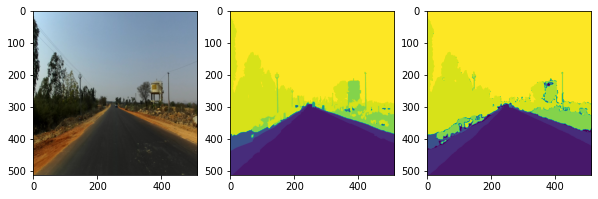

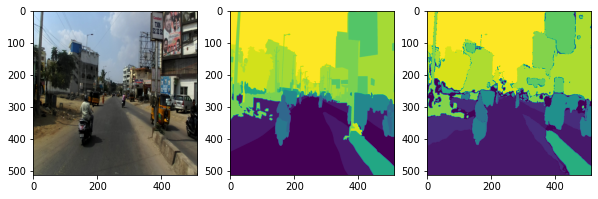

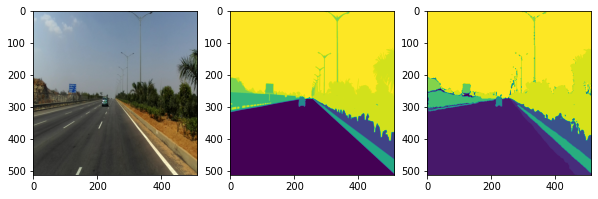

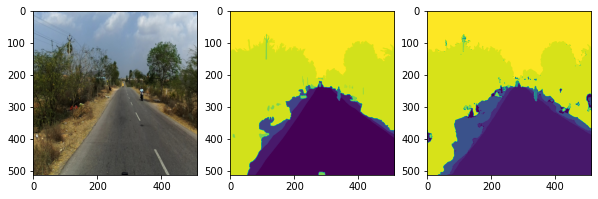

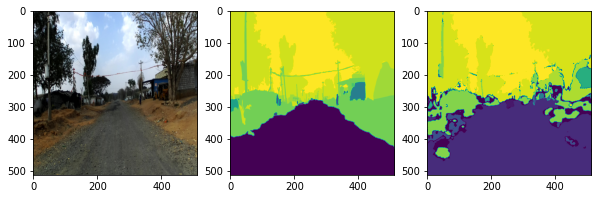

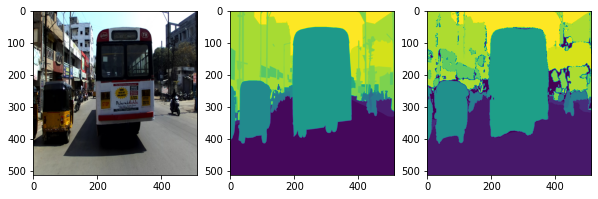

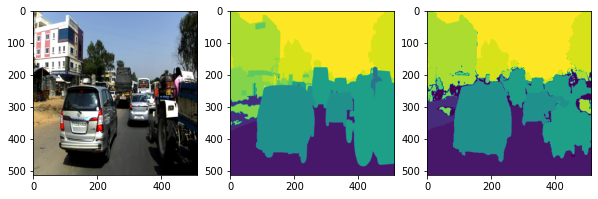

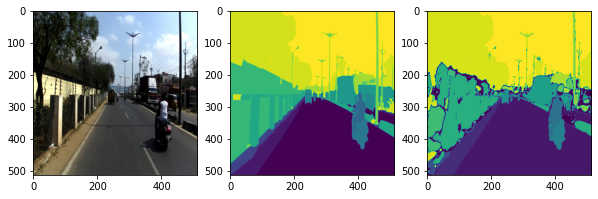

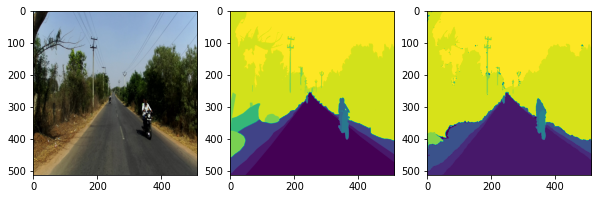

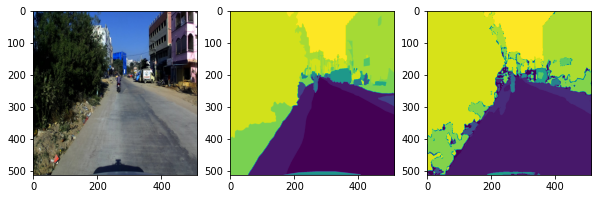

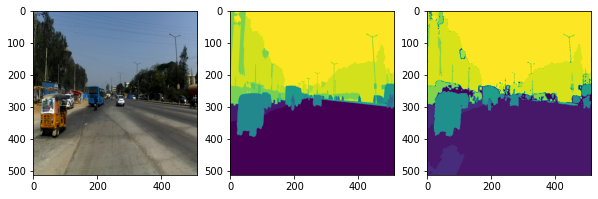

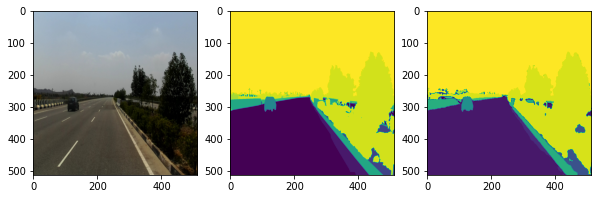

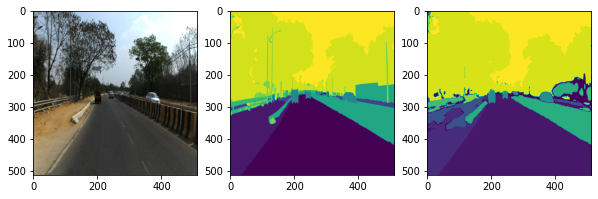

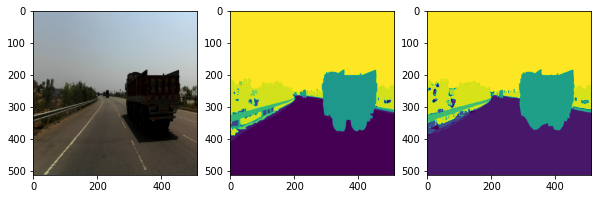

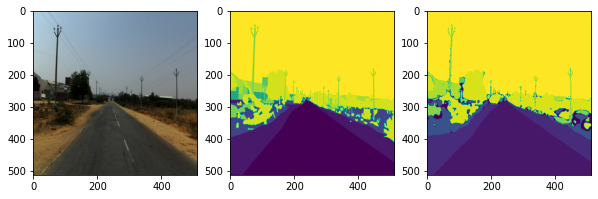

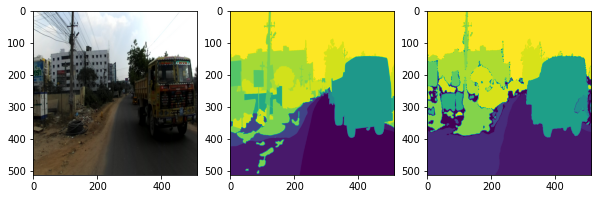

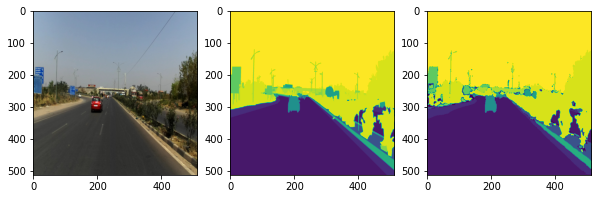

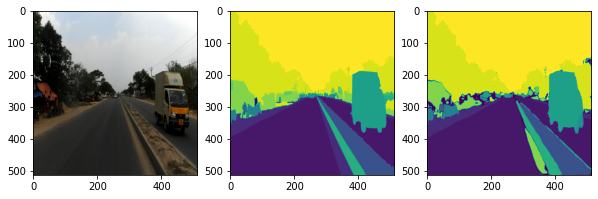

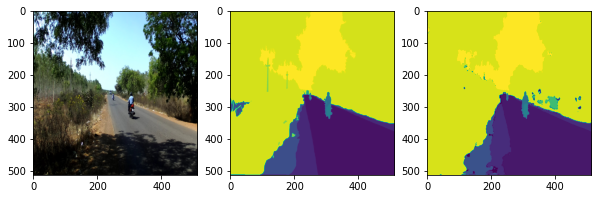

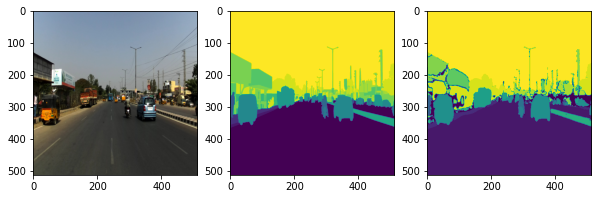

In [ ]:
predict_image(model_best_unet, X_test_df, num_of_images=20)